# TAREA 1 : Grupo 8 (**Javier Muñoz de Torres y Alvaro Morán Lorente**)<br>


**Datos**: Trabajaremos con un conjunto de datos del ambito de medicina/salud, concretamente en relación a problemas al corazón. Los datos vienen de la unión de otros 4 datasets procedentes de Cleveland; Hungary; Switzerland y VA Long Beach, y han sido tomados de pacientes de hospitales.

**Base de datos**: [Heart Disease](https://archive.ics.uci.edu/dataset/45/heart+disease)<br>
En el conjunto de datos el target `num` es categórica, por lo que nos centraremos en una tarea de clasificación. Tiene un rango (0,4), es decir, 5 posibles niveles, que indican de menor a mayor la presencia de un problema en el corazon. El objetivo de este análisis es clasificar los pacientes, dados los atributos que mostraremos a continuación, según "la presencia de problemas" de corazon, lo que se puede interpretar con "como de probable es que tengas un problema de corazón".

**Interpretación del target:** <br>
Para darle un significado a ese rango (0,4), diremos que:<br>
`0` &rarr; Poco probable<br>
`1` &rarr; Algo probable<br>
`2` &rarr; Probable<br>
`3` &rarr; Bastante probable<br>
`4` &rarr; Muy probable<br>
Para nuestro análisis binarizaremos la variable objetivo (**`target`**). Asignaremos como clase positiva `1` aquellos diagnósticos en los que el estrechamiento de arterias es superior al 50% (problemas graves de corazón) y le asignaremos la clase negativa `0` a aquellos casos en los que el estrechamiento de arterias sea inferior al 50% (ausencia de problemas de corazón).
A continuación, analizaremos los atributos (features):

## Sección I. Análisis descriptivo y exploratorio de la base de datos. Preprocesamiento

Cargamos las librerias necesarias a lo largo de nuestro proyecto.

In [76]:

import warnings
import numpy as np
from sklearn.metrics import *
import pandas as pd
from ucimlrepo import fetch_ucirepo
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
warnings.filterwarnings('ignore')


### *Primer vistazo a los datos*

In [6]:


# Dataset
heart_disease = fetch_ucirepo(id=45)
# Datos (dataframes de pandas)
X = heart_disease.data.features # Features
Y = heart_disease.data.targets # Target
features = X.columns
# Ajustamos el tipo de las variables categóricas
categorical_features = ['cp', 'restecg', 'slope', 'thal']
X[categorical_features] = X[categorical_features].astype('category')


Lo primero que hemos hecho ha sido guardar en una variable nuestro conjunto de datos. A continuación, hemos separado en dos DataFrames distintos tanto el target `Y` como las características `X` del conjunto de datos.


In [7]:
heart_disease.variables

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,None,years,no
1,sex,Feature,Categorical,Sex,None,None,no
2,cp,Feature,Categorical,None,None,None,no
3,trestbps,Feature,Integer,None,resting blood pressure (on admission to the ho...,mm Hg,no
4,chol,Feature,Integer,None,serum cholestoral,mg/dl,no
5,fbs,Feature,Categorical,None,fasting blood sugar > 120 mg/dl,None,no
6,restecg,Feature,Categorical,None,None,None,no
7,thalach,Feature,Integer,None,maximum heart rate achieved,None,no
8,exang,Feature,Categorical,None,exercise induced angina,None,no
9,oldpeak,Feature,Integer,None,ST depression induced by exercise relative to ...,None,no


Podemos observar que tenemos una mezcla de variables categoricas y numéricas, por lo que deberemos tenerlo en cuenta ya que habra que hacer alguna modificación con dichas variables categóricas en función de que tipo de modelo usemos (probablemente las utilizaremos en el formato one hot encoding).  
Entre nuestras características vemos que `ca` y `thal` contienen valores faltantes, por lo que tendremos que tratarlos posteriormente.
Como comentamos anteriormente vemos que el target presenta 5 categorias, pero nosotros los binarizaremos distinguiendo entre "presencia de problemas de corazón" (categorias: `1`, `2`, `3`, `4`) y "ausencia de problemas de corazón" (categoría: `0`).  

In [8]:
# Diseño y Test
X_Diseño, X_test, Y_Diseño, Y_test = train_test_split(X, Y, test_size=0.3, random_state=123) # 70% Diseño , 30% Test


Separamos nuestro conjunto de datos en 2 subconjuntos (`diseño` y `test`). **Diseño** contiene un 70% de la muestra, y **test** contiene el 30%.  Vamos a utilizar el conjunto de diseño para realizar el **Grid Search** y para el entrenamiento de los modelos.

In [9]:
continuous_features = X_Diseño.select_dtypes(include=['float64', 'int64']).columns
X_Diseño.describe()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca
count,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,208.000000
mean,54.000000,0.674528,131.834906,244.985849,0.141509,150.382075,0.306604,1.126415,0.677885
std,9.045436,0.469660,18.020949,52.874212,0.349371,21.868635,0.462175,1.216303,0.946436
min,29.000000,0.000000,94.000000,131.000000,0.000000,96.000000,0.000000,0.000000,0.000000
25%,47.750000,0.000000,120.000000,211.000000,0.000000,136.750000,0.000000,0.000000,0.000000
50%,55.000000,1.000000,130.000000,239.500000,0.000000,153.500000,0.000000,0.800000,0.000000
75%,60.250000,1.000000,140.000000,270.000000,0.000000,166.000000,1.000000,1.800000,1.000000
max,76.000000,1.000000,200.000000,564.000000,1.000000,202.000000,1.000000,6.200000,3.000000


Las variables continuas tienen rangos distintos, de modo que habrá que normalizarlas para su posterior visualización y uso en ciertos modelos de machine learning.

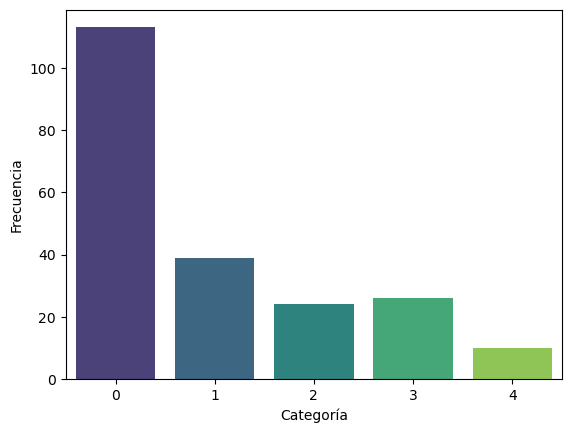

In [10]:
sns.countplot(x='num',data=Y_Diseño, palette="viridis")
plt.ylabel('Frecuencia')
plt.xlabel('Categoría')
plt.show()

Al visualizar la distribución de las clases de nuestra variable objetivo vemos que las clases están desbalanceadas, siendo la clase `0` la más frecuente.  
Procedemos a binarizar el target.  

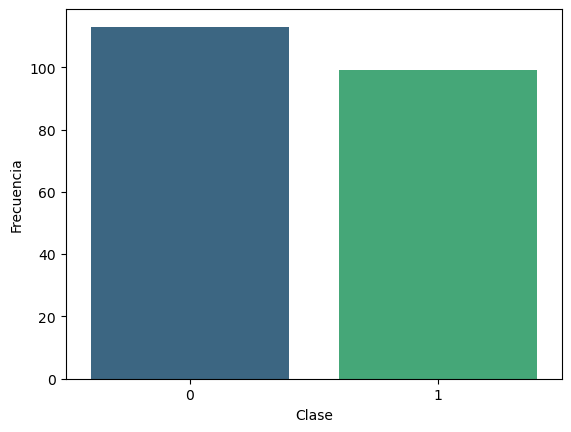

In [11]:
# Pasamos el target a binario
Y_Diseño[Y_Diseño >= 1] = 1
Y_test[Y_test >=1] = 1
sns.countplot(x='num',data=Y_Diseño, palette="viridis")
plt.ylabel('Frecuencia')
plt.xlabel('Clase')
plt.show()

Con las nuevas clases nos ha quedado una distribución mas balanceada, por lo que a la hora de usar figuras de mérito tenemos más libertad de elección. Sin embargo, en este modelo es más relevante predecir correctamente la clase en personas que tienen potenciales problemas de corazón para que las que no, por lo que nos centraremos en acertar los verdaderos positivos, y no tanto los verdaderos negativos.


#### Features

`age`: Edad del paciente tratado <br>
+ **Entera** [min = *29*, max = *76*]
+ **Unidades** &rarr; Años

`sex`: Sexo del paciente tratado <br>
+ **Binaria** [**1** = *hombre*, **0** = *mujer*]
+ **Unidades** &rarr; Sin unidades

`cp`: Tipo de dolor en el pecho <br>
+ **Categórica** [*Angina típica, angina atípica, dolor no anginoso, asintomático*]
+ **Unidades** &rarr; Sin unidades

`trestbps`: Presión arterial en reposo al llegar al hospital<br>
+ **Continua** [min = *94*, max = *192*]
+ **Unidades** &rarr; mm-Hg

`chol`: Colesterol sérico<br>
+ **Continua** [min = *131*, max = *564*]
+ **Unidades** &rarr; mg/dl

`fbs`: Glucemia (azucar en sangre) en ayunas<br>
+ **Binaria** [**1** = *>120*, **0** = *<120*]
+ **Unidades** &rarr; mg/dl

`restecg`: Resultados electrocardiográficos en reposo<br>
+ **Categórica** [**0** = normal,   **1** = con anomalía de la onda ST-T,   **2** = mostrando hipertrofia ventricular izquierda probable o definida según los criterios de Estes]
+ **Unidades** &rarr; Sin unidades

`thalach`: Frecuencia cardíaca máxima alcanzada<br>
+ **Entera** [min = *96*, max = *202*]
+ **Unidades** &rarr;  **?¿?¿?¿?¿?¿??¿??¿?**

`exang`: Angina inducida por el ejercicio<br>
+ **Binaria** [**1** = **Yes**, **0** = **No**]
+ **Unidades** Sin unidades

`oldpeak`: Depresión del segmento ST inducida por el ejercicio en relación con el reposo<br>
+ **Entera** [min = **0** = min, max = **6.2**]
+ **Unidades** ?¿?¿?¿¿?¿?¿?¿?¿??¿?

`slope`: La pendiente del segmento ST en el pico del ejercicio <br>
+ **Categórica** [*Pendiente ascendente , plana, pendiente descendente*]
+ **Unidades** &rarr; Sin unidades

`ca`: Número de vasos principales (0-3) coloreados por fluoroscopia <br>
+ **Entera** [min = **0**, max = **3**]
+ **Unidades** &rarr; Sin unidades

`thal`: Prueba de tálamo o talio <br>
+ **Categórica** [*Normal , efecto fijo, efecto reversble*]
+ **Unidades** &rarr; Sin unidades

#### Target<br>

`num`: Diagnóstico de patología del corazón (estrechamiento/estenosis de las arterias coronarias)<br>
+ **Binaria** [**1** = **grave (Estrechamiento>50%)**, **0** = **leve (Estrechamiento<50%)**]
+ **Unidades** &rarr; Sin unidades

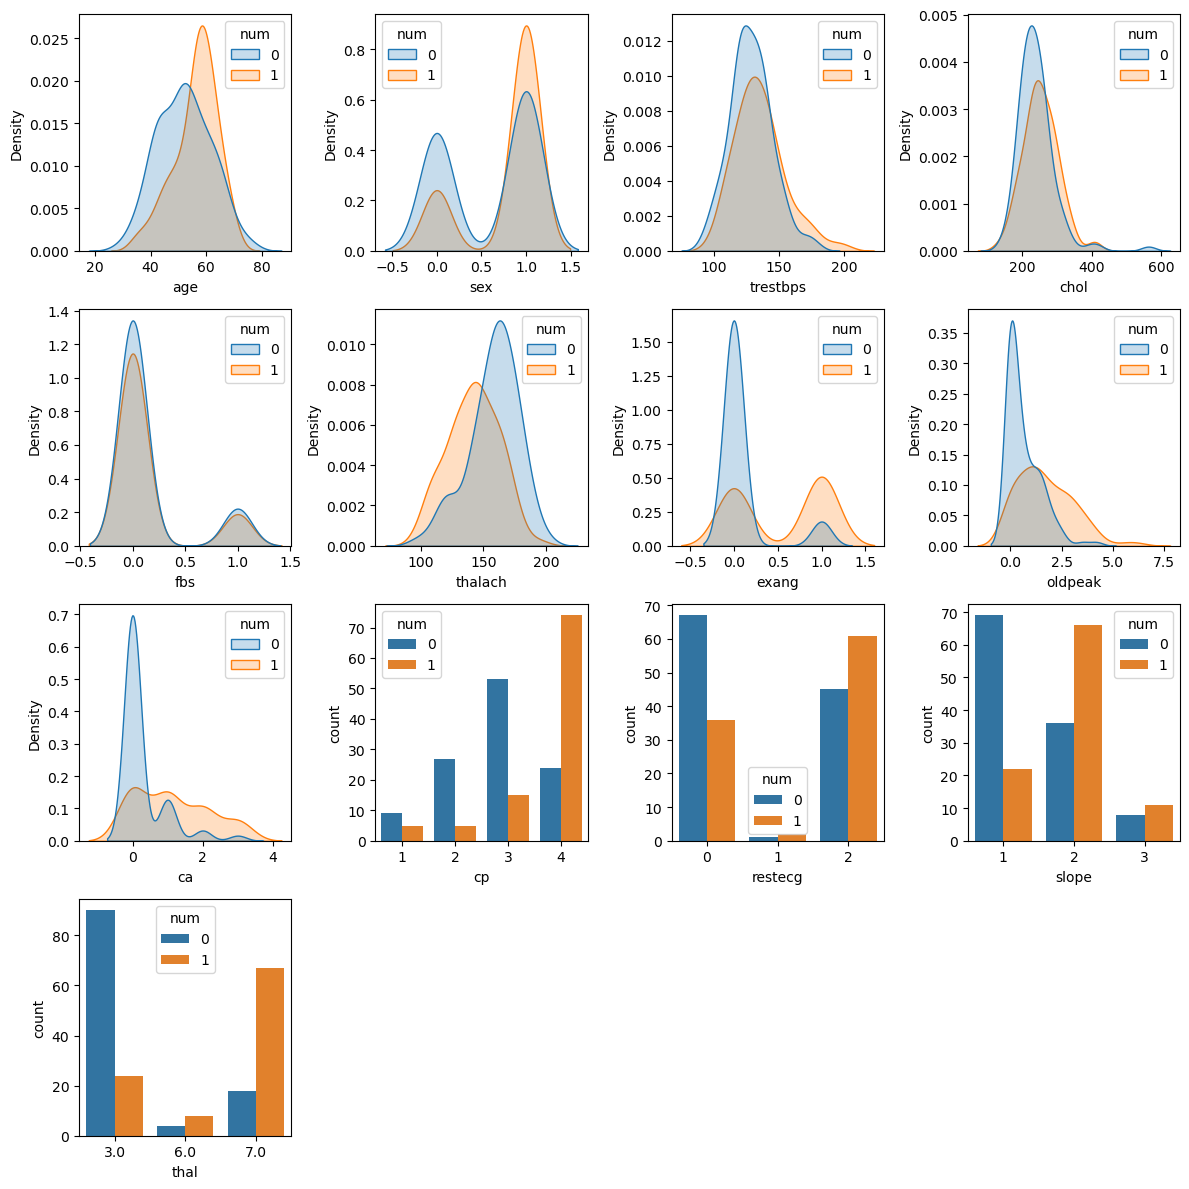

In [12]:
# Vamos a visualizar nuestras variables.
i = 1
plt.figure(figsize=(12,12))
for columna in continuous_features:
    plt.subplot(4,4,i)
    sns.kdeplot(data = X_Diseño, x = columna, fill =True, hue = Y_Diseño['num'])
    i += 1

for columna in categorical_features:
    plt.subplot(4,4,i)
    sns.countplot(data = X_Diseño, x = columna, hue = Y_Diseño['num'])
    i += 1
plt.tight_layout()
plt.show()
    

Tras visualizar los datos diferencia por las categorías del target vemos que pueden ser de interes las características  `sex`, `thalach`, `exang`, `thal` y `cp`.

### Estandarización de los datos

Como hemos mencionado previamente, las variables continuas tienen distintas escalas, por lo que vamos a estandarizarlas para poder calcular distancias de forma correcta.

In [13]:


X_Diseño_scaled = X_Diseño.copy()
X_test_scaled = X_test.copy()
scaler = StandardScaler()

X_Diseño_scaled[continuous_features] = scaler.fit_transform(X_Diseño_scaled[continuous_features])

X_test_scaled[continuous_features] = scaler.transform(X_test_scaled[continuous_features])


### Missing Values


A continuación vamos a analizar las variables `ca` y `thal`, las cuales sabemos que contiene valores faltantes gracias al proveedor de los datos. <br>

Como `ca` acepta el valor **0** vamos a considerar como valores faltantes a los **NaN**, y al ser `thal` una variable categórica, no puede contener, por lo que vamos a usar el mismo criterio.

In [14]:

# Buscar Nulls (NaN)
print("Numero de NaN en ca :",X["ca"].isnull().sum())
print("Numero de NaN en thal:",X["thal"].isnull().sum())
print("Numero de NaN en ca en Diseño:",X_Diseño["ca"].isnull().sum())
print("Numero de NaN en thal en Diseño:",X_Diseño["thal"].isnull().sum())

Numero de NaN en ca : 4
Numero de NaN en thal: 2
Numero de NaN en ca en Diseño: 4
Numero de NaN en thal en Diseño: 1


Como se puede ver, el conjunto de datos contiene algunos valores faltantes en ambas variables; sin embargo, al realizar la partición, `thal` no contiene valores faltantes en este subconjunto. Vamos a proceder con el tratamiento de estos NaN. Dado que son pocos, el tipo de tratamiento que apliquemos no es muy relevante. Sin embargo, realizaremos la imputación considerando un número mayor de NaN, utilizando el método de **k-NN**.

In [15]:
# Imputadores
knn_imputer = KNNImputer(n_neighbors=3)
cat_imputer = SimpleImputer(strategy='most_frequent')

# Separar las columnas numéricas y categóricas de X_Diseño_scaled
X_Diseño_continuous = X_Diseño_scaled[continuous_features]
X_Diseño_categorical = X_Diseño_scaled[categorical_features]

# Imputar las columnas numéricas
X_Diseño_continuous_imputed = knn_imputer.fit_transform(X_Diseño_continuous)
X_Diseño_continuous_imputed = pd.DataFrame(X_Diseño_continuous_imputed, columns=continuous_features)

# Imputar las columnas categóricas
X_Diseño_categorical_imputed = cat_imputer.fit_transform(X_Diseño_categorical)
X_Diseño_categorical_imputed = pd.DataFrame(X_Diseño_categorical_imputed, columns=categorical_features)

# Concatenar de nuevo
X_Diseño_scaled = pd.concat([X_Diseño_continuous_imputed, X_Diseño_categorical_imputed], axis=1)

# Repetir el proceso para X_test_scaled
X_test_continuous = X_test_scaled[continuous_features]
X_test_categorical = X_test_scaled[categorical_features]

X_test_continuous_imputed = knn_imputer.transform(X_test_continuous)
X_test_continuous_imputed = pd.DataFrame(X_test_continuous_imputed, columns=continuous_features)

X_test_categorical_imputed = cat_imputer.transform(X_test_categorical)
X_test_categorical_imputed = pd.DataFrame(X_test_categorical_imputed, columns=categorical_features)

X_test_scaled = pd.concat([X_test_continuous_imputed, X_test_categorical_imputed], axis=1)



In [16]:
# Verificamos la imputación
print("Diseño:")
print("\tNumero de NA en ca en Diseño:", X_Diseño_scaled["ca"].isnull().sum())
print("\tNumero de NA en thal en Diseño:", X_Diseño_scaled["thal"].isnull().sum())

print("\nTest:")
print("\tNumero de NA en ca en Test:", X_test_scaled["ca"].isnull().sum())
print("\tNumero de NA en thal en Test:", X_test_scaled["thal"].isnull().sum())

Diseño:
	Numero de NA en ca en Diseño: 0
	Numero de NA en thal en Diseño: 0

Test:
	Numero de NA en ca en Test: 0
	Numero de NA en thal en Test: 0


Hemos remplazado los NaN mediante el modelo K-NN con un k=3 (se podría hacer un grid search y ser más preciso, pero consideramos que para este caso no es muy determinante), es decir, hemos sustituido el valor faltante por la media de las observaciones más parecidas (cercanas, distancia euclidea) a la tratada.

### One hot encoding

Como mencionamos anteriormente, usaremos la técnica *one hot encoding* para numerizar las variables categóricas y asi poder usarlas en los modelos.

In [17]:

# Inicializar el codificador
encoder = OneHotEncoder(sparse_output=False)
# Aplicar el One-Hot Encoder a las columnas categóricas
encoded_features = encoder.fit_transform(X_Diseño_scaled[categorical_features])
# Convertir la salida codificada en un DataFrame con los nombres de las columnas
encoded_feature_names = encoder.get_feature_names_out(categorical_features)
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)
X_Diseño_scaled[categorical_features] = X_Diseño_scaled[categorical_features].astype('category')

# Concatenar las columnas codificadas con las demás columnas de X_Diseño
X_Diseño_encoded = pd.concat([X_Diseño_scaled.drop(columns=categorical_features), encoded_df], axis=1)

#Repetimos para test
encoded_features_test = encoder.transform(X_test_scaled[categorical_features])
encoded_feature_names_test = encoder.get_feature_names_out(categorical_features)
encoded_df_test = pd.DataFrame(encoded_features_test, columns=encoded_feature_names_test)

X_test_encoded = pd.concat([X_test_scaled.drop(columns=categorical_features), encoded_df_test], axis=1)

X_Diseño_preprocesado = X_Diseño_encoded.copy()
X_test_preprocesado = X_test_encoded.copy()


X_Diseño_preprocesado.describe()



,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,cp_1.0,...,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
count,2.120000e+02,2.120000e+02,2.120000e+02,2.120000e+02,2.120000e+02,2.120000e+02,2.120000e+02,2.120000e+02,212.000000,212.000000,...,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000
mean,-8.379042e-18,-1.424437e-16,-2.513713e-17,9.635898e-17,3.351617e-17,5.341639e-16,-6.598495e-17,-6.284281e-17,-0.006885,0.066038,...,0.462264,0.485849,0.014151,0.500000,0.429245,0.481132,0.089623,0.542453,0.056604,0.400943
std,1.002367e+00,1.002367e+00,1.002367e+00,1.002367e+00,1.002367e+00,1.002367e+00,1.002367e+00,1.002367e+00,0.995300,0.248936,...,0.499754,0.500983,0.118393,0.501183,0.496140,0.500826,0.286316,0.499374,0.231631,0.491250
min,-2.770366e+00,-1.439605e+00,-2.104465e+00,-2.160895e+00,-4.059990e-01,-2.492647e+00,-6.649638e-01,-9.282892e-01,-0.717978,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.925916e-01,-1.439605e+00,-6.582848e-01,-6.442893e-01,-4.059990e-01,-6.248374e-01,-6.649638e-01,-9.282892e-01,-0.717978,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.108147e-01,6.946348e-01,-1.020617e-01,-1.039984e-01,-4.059990e-01,1.429126e-01,-6.649638e-01,-2.690017e-01,-0.717978,0.000000,...,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,6.925916e-01,6.946348e-01,4.541614e-01,4.742077e-01,-4.059990e-01,7.158604e-01,1.503841e+00,5.551076e-01,0.341167,0.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,2.437923e+00,6.946348e-01,3.791500e+00,6.047735e+00,2.463060e+00,2.365950e+00,1.503841e+00,4.181189e+00,2.459457,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Ahora tenemos por cada etiqueta de las variable categóricas un atributo binario que indica dicha etiqueta de la observacion.

Tras esto, ya hemos terminado con el preprocesamiento de los datos; hemos solucionado los missing values y trasnformado las variables categóricas. (hay que normalizar las variables continuas)

Ahora vamos a visualizar la matriz de correlacion entre las variables y el target para ver si algun par esta muy linealmente correlado:

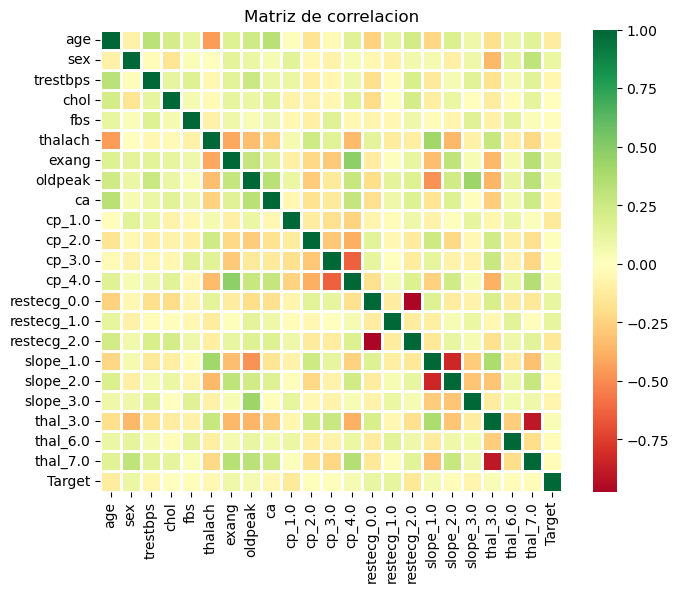

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
X_Y_Diseño = X_Diseño_encoded.copy()
X_Y_Diseño["Target"] = Y_Diseño
corr = X_Y_Diseño.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=False, cmap='RdYlGn', center=0, square=True, linewidths=1)
plt.title("Matriz de correlacion")
plt.show()


De esta gráfica observamos que apenas ningun par esta muy correlacionado, a excepción de algunas como Thal-Target y oldpeak-slope. La información que podemos extraer de aqui es que ningun atributo por si solo esta muy correlada con el target (solo thal se acerca a una buena correlacion positiva) y que los atributos entre si no tienen apenas correlación (lo que nos indica, a priori, que no hay redundancia y que no debemos eliminar ninguo de estos atributos).

Cabe destacar que hay cierta correlación entre las variables que han surgido del One Hot Encoding, pero dicha correlacion es normal por la naturaleza de estas, no es necesario tenerlo en cuenta (conceptualmente, nos dice que si no es de una clase, pues es de otra, lo que no nos da nueva información).



## Sección II. Esquema lineal y selección de características

### *Regresión Logística: todas las variables sin regularizacion*<br>

A continuación vamos a crear un modelo de **regresión logística** usando todas los atributos y sin ningun parámetro de regularización, pero primero escalaremos las variables que hagan falta para obtener mejores resultados.

In [19]:
hiper_parametros = [{'C' : [0.001, 0.01, 0.1, 1, 10, 100], "solver" : ["lbfgs", "liblinear","newton-cg", "newton-cholesky", "sag", "saga"]}]
RegresionLogistica_GS = GridSearchCV(LogisticRegression(penalty=None,random_state= 314), hiper_parametros,  cv=10, scoring='accuracy')
RegresionLogistica_GS.fit(X_Diseño_preprocesado, Y_Diseño)
RegresionLogistica_GS.best_params_


{'C': 0.001, 'solver': 'lbfgs'}

In [20]:
modelo_RL = LogisticRegression(C=0.001, solver='newton-cg', penalty=None, random_state=314)
modelo_RL.fit(X_Diseño_preprocesado, Y_Diseño)
pairs = []
for i in range(len(modelo_RL.coef_[0])):
    pairs.append( (modelo_RL.coef_[0][i], X_Diseño_preprocesado.columns[i]) )
sorted(pairs)

[(-0.9828262177706325, 'cp_1.0'),
 (-0.6966608521082523, 'thal_3.0'),
 (-0.581341375932084, 'cp_3.0'),
 (-0.5633388805305239, 'slope_1.0'),
 (-0.3561452457617638, 'restecg_0.0'),
 (-0.2759661876682957, 'fbs'),
 (-0.22113553311002293, 'slope_3.0'),
 (-0.17539205144422487, 'thal_6.0'),
 (-0.11519437219116264, 'age'),
 (-0.04660442981566006, 'thalach'),
 (-0.012310801030252373, 'chol'),
 (-0.012267781149770146, 'restecg_1.0'),
 (0.15509087190068083, 'cp_2.0'),
 (0.17956371847045208, 'restecg_2.0'),
 (0.3099489241956889, 'trestbps'),
 (0.5140459080033545, 'oldpeak'),
 (0.566141608117244, 'sex'),
 (0.5956251051994648, 'slope_2.0'),
 (0.6435409647784468, 'exang'),
 (0.6832035951113941, 'thal_7.0'),
 (1.1380068486464945, 'ca'),
 (1.2202274133609519, 'cp_4.0')]

Viendo estos coeficientes, podemos intuir que las variables con más impacto sobre el target son cp_1, thal_3, ca y cp_4.0, pues son aquellas cuyo valor absoluto es mayor, ya si es negativo o positivo solo indica si influye a una clase u otra de la variable objetivo. 

Las dos primeras se corresponden con la presencia de una angina típica y con un resultado normal de la prueba del talio. Por otro lado, las otras dos corresponden al número de vasos coloreados por fluoroscopia y asintomático. Los dos primeros no son tan intepretables, pero los dos segundos son claros indicadores de la salud del paciente, ya que indican que sus vasos sanguíeos estan bien (a mayor ca, mas vasos se colorean) y que además el paciente no tiene síntomas (lo que puede indiciar la ausencia de los problemas cardíacos). 

### *Regresión Logística: con regularizacion*<br>
Para seleccionar una regularización, probaremos algunas y nos quedaremos con la que mejor prestaciones nos de:

In [21]:
hiper_parametros = [{'C' : [0.001, 0.01, 0.1, 1, 10, 100], "solver" : ["lbfgs", "liblinear","newton-cg", "newton-cholesky", "sag", "saga"]}]
RegresionLogistica_GS_reg_l1 = GridSearchCV(LogisticRegression(penalty='l1',random_state= 314), hiper_parametros,  cv=10, scoring='accuracy')
RegresionLogistica_GS_reg_l1.fit(X_Diseño_preprocesado, Y_Diseño)
RegresionLogistica_GS_reg_l1.best_params_

{'C': 1, 'solver': 'liblinear'}

In [22]:
hiper_parametros = [{'C' : [0.001, 0.01, 0.1, 1, 10, 100], "solver" : ["lbfgs", "liblinear","newton-cg", "newton-cholesky", "sag", "saga"]}]
RegresionLogistica_GS_reg_l2 = GridSearchCV(LogisticRegression(penalty='l2',random_state= 314), hiper_parametros,  cv=10, scoring='accuracy')
RegresionLogistica_GS_reg_l2.fit(X_Diseño_preprocesado, Y_Diseño)
RegresionLogistica_GS_reg_l2.best_params_

{'C': 1, 'solver': 'lbfgs'}

In [23]:
hiper_parametros = [{'C' : [0.001, 0.01, 0.1, 1, 10, 100], "solver" : ["saga"], "l1_ratio":[0.1,0.2,0.5,0.7]}]
RegresionLogistica_GS_reg_elasticnet = GridSearchCV(LogisticRegression(penalty='elasticnet',random_state= 314), hiper_parametros,  cv=10, scoring='accuracy')
RegresionLogistica_GS_reg_elasticnet.fit(X_Diseño_preprocesado, Y_Diseño)
RegresionLogistica_GS_reg_elasticnet.best_params_

{'C': 0.1, 'l1_ratio': 0.5, 'solver': 'saga'}

In [24]:
print("Accuracy con regularizacion de Lasso en validation:      ",RegresionLogistica_GS_reg_l1.best_score_)
print("Acuraccy con regularizacion de Ridge, en validation:     ",RegresionLogistica_GS_reg_l2.best_score_)
print("Acuraccy con regularizacion de elasticnet, en validation:",RegresionLogistica_GS_reg_elasticnet.best_score_)

Accuracy con regularizacion de Lasso en validation:       0.8344155844155845
Acuraccy con regularizacion de Ridge, en validation:      0.8389610389610389
Acuraccy con regularizacion de elasticnet, en validation: 0.843939393939394


La que mejores prestaciones nos ofrece a priori en este caso es la regularización de elasticnet (combina l1 y l2 junto con un ratio de ambas que tambien hemos optimizado con GridSearch), por lo que nos quedaremos con este modelo:

In [25]:
modelo_RL_reg = LogisticRegression(penalty='elasticnet', l1_ratio=0.5, solver='saga', random_state=314, C=0.1)
modelo_RL_reg.fit(X_Diseño_preprocesado, Y_Diseño)
pairs = []
for i in range(len(modelo_RL_reg.coef_[0])):
    pairs.append( (modelo_RL_reg.coef_[0][i], X_Diseño_preprocesado.columns[i]) )
sorted(pairs)

[(-0.4464310145084605, 'thal_3.0'),
 (-0.11414622516387962, 'thalach'),
 (-0.047469685083838864, 'cp_3.0'),
 (-0.03597612795141989, 'slope_1.0'),
 (-0.003763229074696501, 'fbs'),
 (0.0, 'age'),
 (0.0, 'chol'),
 (0.0, 'cp_1.0'),
 (0.0, 'cp_2.0'),
 (0.0, 'restecg_0.0'),
 (0.0, 'restecg_1.0'),
 (0.0, 'restecg_2.0'),
 (0.0, 'slope_3.0'),
 (0.0, 'thal_6.0'),
 (0.06251972320398612, 'trestbps'),
 (0.12085801291579322, 'slope_2.0'),
 (0.1842596690976797, 'sex'),
 (0.37594587071559094, 'oldpeak'),
 (0.3801143619495571, 'thal_7.0'),
 (0.5094786170802045, 'exang'),
 (0.5683208412978076, 'cp_4.0'),
 (0.6014785033019001, 'ca')]

Tras aplicar la regularizacion, las variables mas importantes son:<br>
* **Positivamente**<br>
    `1` ca : Nº Vasos princiaples coloreados <br>
    `2` cp_4 : Asintomatico (1 = si, 0 = no)  <br>
    `3` exang : Angina inducida por el ejercicio (1 = Si, 0 = No) <br>
* **Negativamente**<br>
    `1` thal_3 : Prueba del talamo -> Normal () <br>
    `2` thalach : Frecuencia cardíaca máxima alcanzada <br>

A la hora de interpretar, es normal que se relacione positivamente el numero de vasos principales coloreados con la salud cardiaca, ya que indican que dichos vasos funcionan correctamente. Por otro lado, que el paciente sea asintomático no debería soprender que sugiera la ausencia de problemas cardíacos.

Tras esto, vamos a ver el desempeño del modelo usando 4 figuras de mérito.

In [ ]:
# Modelo 
modelo_RL_wrapped = LogisticRegression(penalty = None, solver='saga', random_state=314, C=0.1)
modelo_RL_wrapped.fit(X_Diseño_preprocesado,Y_Diseño)
Y_output_wrapper = modelo_RL_wrapped.predict(X_test_preprocesado)

# Figuras de mérito
accuracy_wrapper = accuracy_score(Y_test,Y_output_wrapper)
f1_wrapper = f1_score(Y_test,Y_output_wrapper)
precision_wrapper = precision_score(Y_test,Y_output_wrapper)
recall_wrapper = recall_score(Y_test,Y_output_wrapper)

figuras_wrapper_RG_reg = {'metodo':['RL'],'accuracy':[accuracy_wrapper],'f1_score':[f1_wrapper],'precision':[precision_wrapper],'recall':[recall_wrapper]}
figuras_wrapper_RG_reg = pd.DataFrame(figuras_wrapper_RG_reg)
figuras_wrapper_RG_reg


,metodo,accuracy,f1_score,precision,recall
0,MLP_WRAPPER,0.846154,0.815789,0.861111,0.775


A priori el modelo parece que se desempeña bien para esta tarea de clasificación, aunque flaquea un poco en la tasa de verdaderos postivos (recall).

### Wrapped
Para la selección de características usaremos los métodos _Backward_ y _Forward_. Usaremos el modelo sin regularización para comparar las variables seleccionadas finalmente con las que no tienen coeficientes nulo al aplicar el penalty.

#### BACKWARD

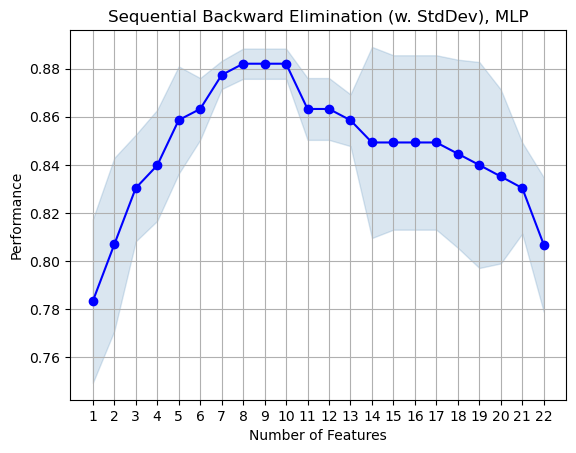

In [89]:
sfs_be = SFS(modelo_RL, 
           k_features=(1,22), 
           forward=False, 
           floating=False, 
           scoring='accuracy',
           cv=3)

sfs_bw = sfs_be.fit(X_Diseño_preprocesado, Y_Diseño)

# Representar los resultados
fig1 = plot_sfs(sfs_bw.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Elimination (w. StdDev), MLP')
plt.grid()
plt.show()

wrapped_backward = pd.DataFrame.from_dict(sfs_be.get_metric_dict()).T

In [92]:
features = wrapped_backward.loc[8,'feature_names']
print(f'Las variables obtenidas son: {features}')

Las variables obtenidas son: ('sex', 'ca', 'cp_1.0', 'cp_2.0', 'cp_3.0', 'cp_4.0', 'restecg_1.0', 'thal_3.0')


#### FORWARD

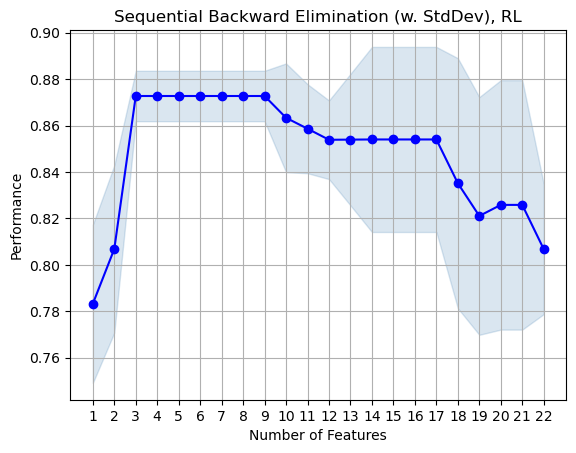

In [ ]:
sfs_be = SFS(modelo_RL, 
           k_features=(1,22), 
           forward=True, 
           floating=False, 
           scoring='accuracy',
           cv=3)

sfs_fw = sfs_be.fit(X_Diseño_preprocesado, Y_Diseño)

# Representar los resultados
fig1 = plot_sfs(sfs_be.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Elimination (w. StdDev), RL')
plt.grid()
plt.show()

wrapped_backward = pd.DataFrame.from_dict(sfs_be.get_metric_dict()).T

In [144]:
features = wrapped_backward.loc[3,'feature_names']
print(f'Las variables obtenidas son: {features}')

Las variables obtenidas son: ('ca', 'cp_4.0', 'thal_3.0')


Tras estos dos resultados, concluimos que lo mejor sera coger las 8 variables seleccionadas con backward, que tiene una significante mejora del valor accuracy frente al forward.

Comparando con la regularización, teniamos [**'cp_4'**, exang, **'thal_3'**,  thalach] como variables más relevantes (coeficientes más altos) y no nos soprende que, al hacer feature selection, nos salgan 2 variables en común: ['ca', '**'cp_4.0'**', '**'thal_3.0'**']


In [139]:
RL_features = list(wrapped_backward.loc[3,'feature_names'])

Veamos ahora que resultados tenemos.

In [ ]:
# Modelo 
X_diseno_wrapped = X_Diseño_preprocesado[RL_features]
modelo_RL_wrapped = LogisticRegression(penalty = None, solver='saga', random_state=314, C=0.1)
modelo_RL_wrapped.fit(X_diseno_wrapped,Y_Diseño)
Y_output_wrapper = modelo_RL_wrapped.predict(X_test_preprocesado[RL_features])

# Figuras de mérito
accuracy_wrapper = accuracy_score(Y_test,Y_output_wrapper)
f1_wrapper = f1_score(Y_test,Y_output_wrapper)
precision_wrapper = precision_score(Y_test,Y_output_wrapper)
recall_wrapper = recall_score(Y_test,Y_output_wrapper)

figuras_wrapper = {'metodo':['RL_WRAPPER_FORWARD'],'accuracy':[accuracy_wrapper],'f1_score':[f1_wrapper],'precision':[precision_wrapper],'recall':[recall_wrapper]}
figuras_wrapper = pd.DataFrame(figuras_wrapper)
figuras_wrapper

,metodo,accuracy,f1_score,precision,recall
0,MLP_WRAPPER,0.791209,0.759494,0.769231,0.75


Comparandolo con los resultados anteriores, las métricas salen algo inferiores. Esto es completamente normal, pues al usar menos variables la precision baja (aunque también el sobreajuste). Si necesitasemos reducir mucho la complejidad computacional podríamos optar por esta última opción, pero en general el modelo con regularización que hemos obtenido anteriormente es significantemente superior, asique optaríamos por él.

## Sección 3: Perceptrón Multicapa o MLP (Multi-Layer Perceptron)

Utilizar un MLP con una única capa oculta es razonable porque se trata de una tarea de clasificación sencilla,y aunque las observaciones siguieran una relación no lineal la red neuronal sería capaz de encontrarla al usar funciones de activación no lineales, y por ese mismo motivo se considera que el MLP es un "aproximador universal". 

Hemos utilizado nuestro conjunto de entrenamiento normalizado ya que el aprendizaje de una red neuronal depende del algoritmo de descenso de gradiente.<br>

En caso de no estar escalados, este algoritmo dara mucha más importancia a los atributos con valores más grandes, por lo que se crearía un sesgo donde se le da más importancia a ciertos atributos. Además de esto, surgen otros problemas como al poner regularización (se penaliza mucho más a los que tengan escala mayor), funciones de activación no lineales (se satura constantemente y impide un correcto aprendizaje) y también le dificulta la convergencia al descenso de gradiente (ya que la actualizacion de pesos esta muy desbalanceada).<br>

En conclusión, escalar los datos es esecial para este modelo.

### Una única capa oculta

#### TANH

A continuación creamos nuestra red neuronal utilizando como función de activación la tangente hiperbólica. Vamos a utilizar un batch que contenga todas las observaciones. Mediante GridSearch usando validación cruzada buscamos el número de neuronas más optimo y el mejor solver, todo ello para maximizar el accuracy de nuestro modelo.

In [26]:
# Obtenemos el numero de observaciones
n_obs = X_Diseño_preprocesado.shape[0]
# Ajustamos los hiperparametros a buscar por el gridsearch
param_grid = {'hidden_layer_sizes': range(2,152,5),'solver':['lbfgs','sgd','adam'],'batch_size':[n_obs]}
neuronas_ocultas_grid = np.array(range(2,152,5))

mlp_cv_tanh = GridSearchCV(MLPClassifier(max_iter = 500, random_state=714, activation='tanh'), param_grid = param_grid, scoring = 'accuracy', cv=3,return_train_score=True )
mlp_cv_tanh.fit(X_Diseño_preprocesado,Y_Diseño)

GridSearchCV(cv=3,
             estimator=MLPClassifier(activation='tanh', max_iter=500,
                                     random_state=714),
             param_grid={'batch_size': [212],
                         'hidden_layer_sizes': range(2, 152, 5),
                         'solver': ['lbfgs', 'sgd', 'adam']},
             return_train_score=True, scoring='accuracy')

Una vez hecho el gridsearch con validación cruzada vamos a representar como cambia el accuracy según el número de neuronas.

In [27]:
resultados = pd.DataFrame(mlp_cv_tanh.cv_results_)
train_tanh = resultados[resultados['param_solver'] == 'sgd'].mean_train_score
validation_tanh = resultados[resultados['param_solver'] == 'sgd'].mean_test_score


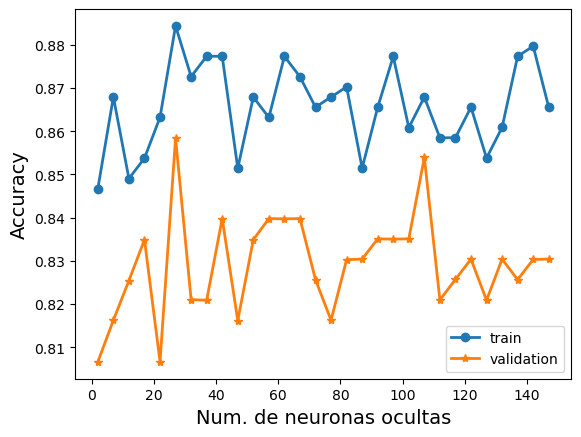

Utilizando como solver "sgd" y "tanh" como función de activación el mejor número de neuronas en la capa oculta es: 27 con un accuracy de 0.8584171696847753


In [28]:
plt.plot(neuronas_ocultas_grid,train_tanh,'-o',label="train", linewidth=2)
plt.plot(neuronas_ocultas_grid,validation_tanh,'-*',label="validation", linewidth=2)
plt.xlabel('Num. de neuronas ocultas',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.legend()
plt.show()
best_layer_size_tanh = mlp_cv_tanh.best_params_['hidden_layer_sizes']
print(f'Utilizando como solver "sgd" y "tanh" como función de activación el mejor número de neuronas en la capa oculta es: {best_layer_size_tanh} con un accuracy de {mlp_cv_tanh.best_score_}')

Tras analizar los resultados obtenidos comprobamos que los resultados para validation no terminan de estabilizarse.<br>

#### RELU

Ahora exploraremos la búsqueda de hiperparámetros usando otras funciones de activación. Comenzaremos usando la "relu".

In [29]:
mlp_cv_relu = GridSearchCV(MLPClassifier(max_iter = 500, random_state=714, activation='relu'), param_grid = param_grid, scoring = 'accuracy', cv=3,return_train_score=True )
mlp_cv_relu.fit(X_Diseño_preprocesado,Y_Diseño)
print(f'El mejor solver cuando la función de activación es "relu" es: {mlp_cv_relu.best_params_['solver']}')

El mejor solver cuando la función de activación es "relu" es: sgd


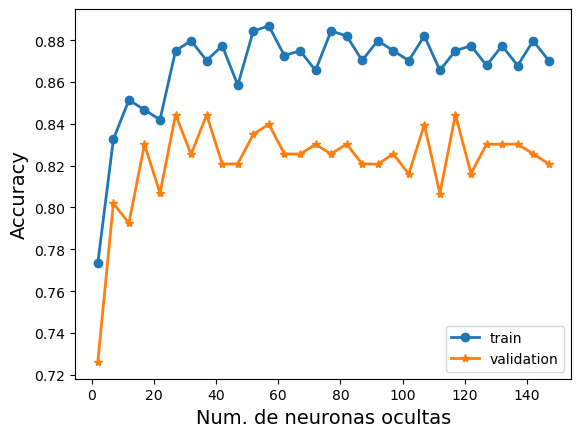

Utilizando como solver "sgd" y "relu" como función de activación el mejor número de neuronas en la capa oculta es: 27 con un accuracy de 0.8443997317236754


In [30]:
resultados = pd.DataFrame(mlp_cv_relu.cv_results_)
train_relu = resultados[resultados['param_solver'] == 'sgd'].mean_train_score
validation_relu = resultados[resultados['param_solver'] == 'sgd'].mean_test_score
plt.plot(neuronas_ocultas_grid,train_relu,'-o',label="train", linewidth=2)
plt.plot(neuronas_ocultas_grid,validation_relu,'-*',label="validation", linewidth=2)
plt.xlabel('Num. de neuronas ocultas',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.legend()
plt.show()
best_layer_size_relu = mlp_cv_relu.best_params_['hidden_layer_sizes']
print(f'Utilizando como solver "sgd" y "relu" como función de activación el mejor número de neuronas en la capa oculta es: {best_layer_size_relu} con un accuracy de {mlp_cv_relu.best_score_}')

Utilizando como función de activación 'relu', podemos ver que ahora si se empieza a estabilizar un poco, por lo que en este caso el número óptimo de neuronas sería 70-80.<br>

#### LOGISTIC (sigmoid)

Por último buscaremos el número de neuronas por capa oculta para la función de activación "logistic" función sigmoide.

In [31]:
mlp_cv_sigm = GridSearchCV(MLPClassifier(max_iter = 500, random_state=714, activation='logistic'), param_grid = param_grid, scoring = 'accuracy', cv=3,return_train_score=True )
mlp_cv_sigm.fit(X_Diseño_preprocesado,Y_Diseño)
print(f'El mejor solver cuando la fucnión de activación es la sigmoide es: {mlp_cv_sigm.best_params_['solver']}')

El mejor solver cuando la fucnión de activación es la sigmoide es: adam


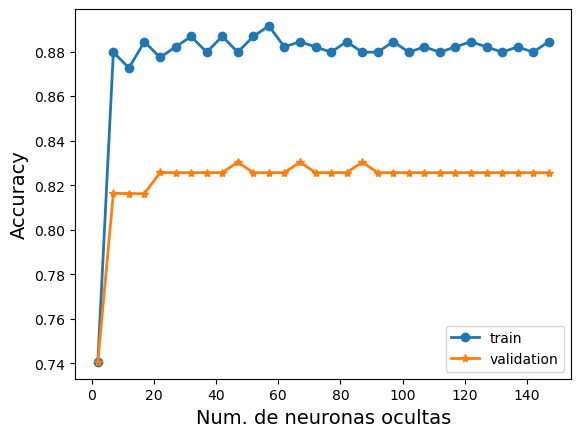

Utilizando como solver "adam" y "logistic" o sigmoide como función de activación el mejor número de neuronas en la capa oculta es: 67 con un accuracy de 0.8303822937625754


In [32]:
resultados = pd.DataFrame(mlp_cv_sigm.cv_results_)
train_sigm = resultados[resultados['param_solver'] == 'adam'].mean_train_score
validation_sigm = resultados[resultados['param_solver'] == 'adam'].mean_test_score
plt.plot(neuronas_ocultas_grid,train_sigm,'-o',label="train", linewidth=2)
plt.plot(neuronas_ocultas_grid,validation_sigm,'-*',label="validation", linewidth=2)
plt.xlabel('Num. de neuronas ocultas',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.legend()
plt.show()
best_layer_size_sigm = mlp_cv_sigm.best_params_['hidden_layer_sizes']
print(f'Utilizando como solver "adam" y "logistic" o sigmoide como función de activación el mejor número de neuronas en la capa oculta es: {best_layer_size_sigm} con un accuracy de {mlp_cv_sigm.best_score_}')


In [33]:
# Convertir los resultados a DataFrame
resultados = pd.DataFrame(mlp_cv_sigm.cv_results_)
# Filtrar por solver 'adam' y 22 neuronas ocultas
mean_val_score_22_adam = resultados[
    (resultados['param_hidden_layer_sizes'] == (22,)) &  
    (resultados['param_solver'] == 'adam')              
]['mean_test_score']  

# Mostrar el valor de mean_test_score
print(f"Accuracy en validation para 22 neuronas ocultas y solver 'adam' es: {mean_val_score_22_adam.values[0]}")


Accuracy en validation para 22 neuronas ocultas y solver 'adam' es: 0.8256874580818243


Viendo los resultados, consideramos que el número de neuronas más óptimo es 22 porque a partir de ese valor del hiperparámetro es cuando el valor de accuracy es más alto y el modelo es estable.

Tras realizar un grid search para buscar el número de neuronas por capa oculta óptimo para cada función de activación, la arquitectura que consideramos la mejor es una red neurnal de una única capa oculta con 22 neuronas, un único batch, 500 épocas, función de activación la función sigmoide y como solver 'adam'.Hemos elegido esta porque es un modelo menos complejo que los otros y con un rendimiento muy similar.

Tras esto, vamos a evaluar el modelo con el conjunto de test y 4 figuras de mérito.

In [155]:
# Modelo
mlp_wrapper = MLPClassifier(max_iter = 500, random_state=714, activation='logistic', solver = 'adam' , hidden_layer_sizes = 22, batch_size=n_obs)
mlp_wrapper.fit(X_Diseño_preprocesado,Y_Diseño)
Y_output_wrapper = mlp_wrapper.predict(X_test_preprocesado)
# Figuras de mérito
accuracy_wrapper = accuracy_score(Y_test,Y_output_wrapper)
f1_wrapper = f1_score(Y_test,Y_output_wrapper)
precision_wrapper = precision_score(Y_test,Y_output_wrapper)
recall_wrapper = recall_score(Y_test,Y_output_wrapper)

figuras_wrapper = {'metodo':['MLP_WRAPPER'],'accuracy':[accuracy_wrapper],'f1_score':[f1_wrapper],'precision':[precision_wrapper],'recall':[recall_wrapper]}
figuras_wrapper = pd.DataFrame(figuras_wrapper)
figuras_wrapper

,metodo,accuracy,f1_score,precision,recall
0,MLP_WRAPPER,0.846154,0.820513,0.842105,0.8


A priori son unos resultados decentes, pero son muy similares a los de la regresión logistica. En este modelo tenemos una mejor tasa de verdaderos positivos, pero un mismo accuracy, por lo que estamos perdiendo simétricamente en la tasa de verdaderos negativos.

### Varias capas ocultas


#### RELU

Primero vamos a a buscar un mejor número de capas ocultas en la estructura cuando la función de activación es una Relu.

In [42]:
hidden_layer_sizes = []
for num_capas in range(1, 31):  
    configuracion = tuple(112 for _ in range(num_capas))
    hidden_layer_sizes.append(configuracion)

param_grid = {
    'hidden_layer_sizes': hidden_layer_sizes,
    'solver': ['sgd',],
    'activation': ['relu'],
    'batch_size': [X_Diseño_preprocesado.shape[0]],  # Batch igual al total de observaciones
}

# Configuramos el GridSearchCV
mlp_cv_layers = GridSearchCV(
    estimator=MLPClassifier(max_iter=500, random_state=714),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    return_train_score=True
)
# Entrenamos el modelo
mlp_cv_layers.fit(X_Diseño_preprocesado, Y_Diseño)

GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=500, random_state=714),
             param_grid={'activation': ['relu'], 'batch_size': [212],
                         'hidden_layer_sizes': [(112,), (112, 112),
                                                (112, 112, 112),
                                                (112, 112, 112, 112),
                                                (112, 112, 112, 112, 112),
                                                (112, 112, 112, 112, 112, 112),
                                                (112, 112, 112, 112, 112, 112,
                                                 112),
                                                (112, 112, 112, 112, 112, 112,
                                                 112, 112),
                                                (112, 112, 112, 112, 112, 112,
                                                 112, 112, 112),
                                                (11...
                                                 112, 112, 112, 112, 112, 112,
                                                 112, 112, 112, 112, 112, 112,
                                                 112, 112, 112, 112),
                                                (112, 112, 112, 112, 112, 112,
                                                 112, 112, 112, 112, 112, 112,
                                                 112, 112, 112, 112, 112, 112,
                                                 112, 112, 112, 112, 112, 112,
                                                 112, 112, 112, 112, 112),
                                                (112, 112, 112, 112, 112, 112,
                                                 112, 112, 112, 112, 112, 112,
                                                 112, 112, 112, 112, 112, 112,
                                                 112, 112, 112, 112, 112, 112,
                                                 112, 112, 112, 112, 112,
                                                 112)],
                         'solver': ['sgd']},
             return_train_score=True, scoring='accuracy')

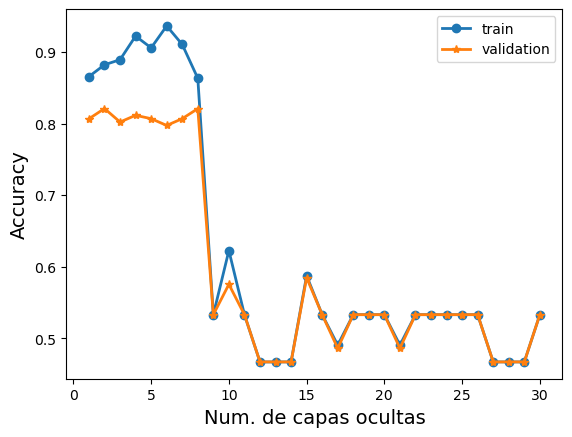

El mejor número de capas ocultas es 2 con un accuracy de: 0.8209255533199196


In [44]:
capas_ocultas_grid = np.array(range(1,31))
plt.plot(capas_ocultas_grid,mlp_cv_layers.cv_results_['mean_train_score'],'-o',label = 'train',linewidth = 2)
plt.plot(capas_ocultas_grid,mlp_cv_layers.cv_results_['mean_test_score'],'-*',label = 'validation',linewidth = 2)
plt.xlabel('Num. de capas ocultas',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.legend()
plt.show()
print(f'El mejor número de capas ocultas es {len(mlp_cv_layers.best_params_['hidden_layer_sizes'])} con un accuracy de: {mlp_cv_layers.best_score_}')

Vemos que añadiento más capas ocultas no conseguimos un mejor rendimiento, por lo que nos quedmos con una única capa oculta resultando en un modelo menos complejo.

#### TANH

Ahora repetiremos el proceso pero utilizando como función de activación la tangente hiperbólica.

In [45]:
hidden_layer_sizes = []
for num_capas in range(1, 31):  
    configuracion = tuple(87 for _ in range(num_capas))
    hidden_layer_sizes.append(configuracion)

param_grid = {
    'hidden_layer_sizes': hidden_layer_sizes,
    'solver': ['sgd',],
    'activation': ['tanh'],
    'batch_size': [X_Diseño_preprocesado.shape[0]],  # Batch igual al total de observaciones
}

# Configuramos el GridSearchCV
mlp_cv_layers = GridSearchCV(
    estimator=MLPClassifier(max_iter=500, random_state=714),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    return_train_score=True
)

# Entrenamos el modelo
mlp_cv_layers.fit(X_Diseño_preprocesado, Y_Diseño)



GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=500, random_state=714),
             param_grid={'activation': ['tanh'], 'batch_size': [212],
                         'hidden_layer_sizes': [(87,), (87, 87), (87, 87, 87),
                                                (87, 87, 87, 87),
                                                (87, 87, 87, 87, 87),
                                                (87, 87, 87, 87, 87, 87),
                                                (87, 87, 87, 87, 87, 87, 87),
                                                (87, 87, 87, 87, 87, 87, 87,
                                                 87),
                                                (87, 87, 87, 87, 87, 87, 87, 87,
                                                 87),
                                                (87, 87, 87, 87, 87, 87, 87, 87,
                                                 87, 87),
                                                (87, 87, 87, 87, 87,...
                                                 87, 87, 87, 87, 87, 87, 87, 87,
                                                 87, 87, 87),
                                                (87, 87, 87, 87, 87, 87, 87, 87,
                                                 87, 87, 87, 87, 87, 87, 87, 87,
                                                 87, 87, 87, 87, 87, 87, 87, 87,
                                                 87, 87, 87, 87),
                                                (87, 87, 87, 87, 87, 87, 87, 87,
                                                 87, 87, 87, 87, 87, 87, 87, 87,
                                                 87, 87, 87, 87, 87, 87, 87, 87,
                                                 87, 87, 87, 87, 87),
                                                (87, 87, 87, 87, 87, 87, 87, 87,
                                                 87, 87, 87, 87, 87, 87, 87, 87,
                                                 87, 87, 87, 87, 87, 87, 87, 87,
                                                 87, 87, 87, 87, 87, 87)],
                         'solver': ['sgd']},
             return_train_score=True, scoring='accuracy')

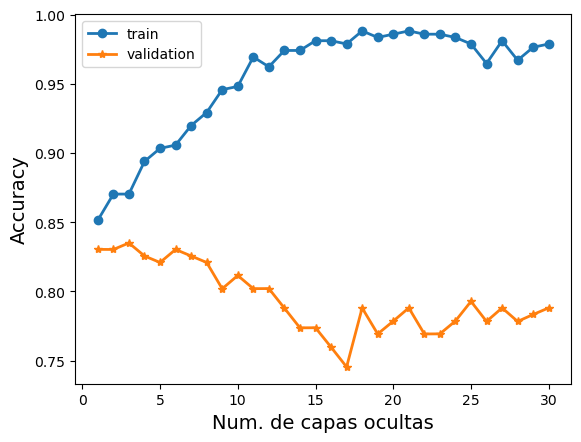

El mejor número de capas ocultas es 3 con un accuracy de: 0.8350100603621731


In [46]:
capas_ocultas_grid = np.array(range(1,31))
plt.plot(capas_ocultas_grid,mlp_cv_layers.cv_results_['mean_train_score'],'-o',label = 'train',linewidth = 2)
plt.plot(capas_ocultas_grid,mlp_cv_layers.cv_results_['mean_test_score'],'-*',label = 'validation',linewidth = 2)
plt.xlabel('Num. de capas ocultas',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.legend()
plt.show()
print(f'El mejor número de capas ocultas es {len(mlp_cv_layers.best_params_['hidden_layer_sizes'])} con un accuracy de: {mlp_cv_layers.best_score_}')

Obtenemos que el mejor número de capas ocultas vuelve a ser una, pero vemos que nuevamente cuando usamos como función de activación la tangente hiperbólica no se estabiliza del todo en ningun punto.

#### LOGISTIC (sigmoid)

Por último lo haremos para la función de activación sigmoide.

In [47]:
hidden_layer_sizes = []
for num_capas in range(1, 31):  
    configuracion = tuple(22 for _ in range(num_capas))
    hidden_layer_sizes.append(configuracion)

param_grid = {
    'hidden_layer_sizes': hidden_layer_sizes,
    'solver': ['adam',],
    'activation': ['logistic'],
    'batch_size': [X_Diseño_preprocesado.shape[0]],  # Batch igual al total de observaciones
}

# Configuramos el GridSearchCV
mlp_cv_layers = GridSearchCV(
    estimator=MLPClassifier(max_iter=500, random_state=714),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    return_train_score=True
)

# Entrenamos el modelo
mlp_cv_layers.fit(X_Diseño_preprocesado, Y_Diseño)


GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=500, random_state=714),
             param_grid={'activation': ['logistic'], 'batch_size': [212],
                         'hidden_layer_sizes': [(22,), (22, 22), (22, 22, 22),
                                                (22, 22, 22, 22),
                                                (22, 22, 22, 22, 22),
                                                (22, 22, 22, 22, 22, 22),
                                                (22, 22, 22, 22, 22, 22, 22),
                                                (22, 22, 22, 22, 22, 22, 22,
                                                 22),
                                                (22, 22, 22, 22, 22, 22, 22, 22,
                                                 22),
                                                (22, 22, 22, 22, 22, 22, 22, 22,
                                                 22, 22),
                                                (22, 22, 22, 22...
                                                 22, 22, 22, 22, 22, 22, 22, 22,
                                                 22, 22, 22),
                                                (22, 22, 22, 22, 22, 22, 22, 22,
                                                 22, 22, 22, 22, 22, 22, 22, 22,
                                                 22, 22, 22, 22, 22, 22, 22, 22,
                                                 22, 22, 22, 22),
                                                (22, 22, 22, 22, 22, 22, 22, 22,
                                                 22, 22, 22, 22, 22, 22, 22, 22,
                                                 22, 22, 22, 22, 22, 22, 22, 22,
                                                 22, 22, 22, 22, 22),
                                                (22, 22, 22, 22, 22, 22, 22, 22,
                                                 22, 22, 22, 22, 22, 22, 22, 22,
                                                 22, 22, 22, 22, 22, 22, 22, 22,
                                                 22, 22, 22, 22, 22, 22)],
                         'solver': ['adam']},
             return_train_score=True, scoring='accuracy')

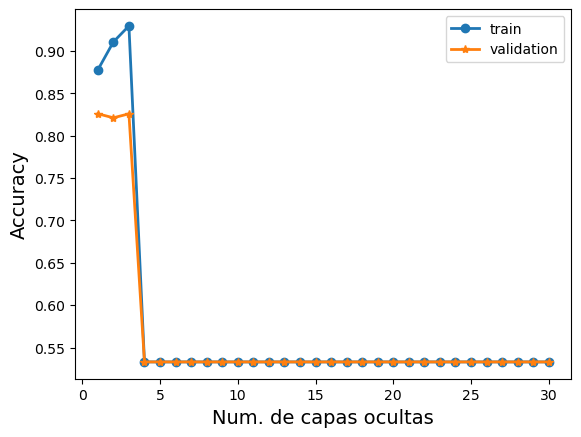

El mejor número de capas ocultas es 1 con un accuracy de: 0.8256874580818243


In [160]:
capas_ocultas_grid = np.array(range(1,31))
plt.plot(capas_ocultas_grid,mlp_cv_layers.cv_results_['mean_train_score'],'-o',label = 'train',linewidth = 2)
plt.plot(capas_ocultas_grid,mlp_cv_layers.cv_results_['mean_test_score'],'-*',label = 'validation',linewidth = 2)
plt.xlabel('Num. de capas ocultas',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.legend()
plt.show()
print(f'El mejor número de capas ocultas es {len(mlp_cv_layers.best_params_['hidden_layer_sizes'])} con un accuracy de: {mlp_cv_layers.best_score_}')

Entre las 3 opciones, concluimos en que el mejor modelo es un MLP con función de activación sigmoide con una capa oculta de 22 neuronas.

Puesto que hemos obtenido el mismo modelo de antes, no es necesario volver a ver su desempeño en test.

### Wrapper

Para el método wrapper utilizaremos el MLP con una única capa usando la función de activación Sigmoide que presenta una accuracy muy similar a cuando utilzamos la función Relu pero con un número bastante menor de neuronas por capa oculta.

Vamos a realizar el método wrapper con backward elimination porque no parece que tengamos muchas características irrelevantes o redundantes y no tenemos un número de características muy grande.

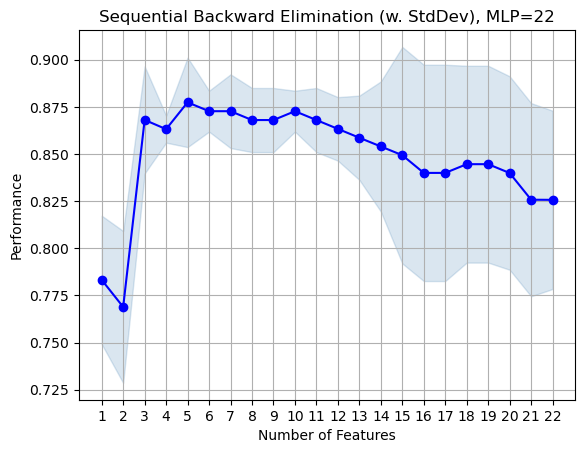

In [87]:
num_neur = 22
mlp_wrapper = MLPClassifier(max_iter = 500, random_state=714, activation='logistic', solver = 'adam' , hidden_layer_sizes = num_neur, batch_size=n_obs)
sfs_be = SFS(mlp_wrapper, 
           k_features=(1,22), 
           forward=False, 
           floating=False, 
           scoring='accuracy',
           cv=3)

sfs_bw = sfs_be.fit(X_Diseño_preprocesado, Y_Diseño)

# Representar los resultados
fig1 = plot_sfs(sfs_bw.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Elimination (w. StdDev), MLP=' + str(num_neur))
plt.grid()
plt.show()

wrapped_backward = pd.DataFrame.from_dict(sfs_be.get_metric_dict()).T

Analizando los resultados podemos ver que el mejor rendimiento se obtiene para 8 variables, veamos cuales.

In [96]:
features = wrapped_backward.loc[6,'feature_names']
print(f'Las variables obtenidas son: {features}')

Las variables obtenidas son: ('sex', 'ca', 'cp_1.0', 'cp_2.0', 'cp_4.0', 'thal_3.0')


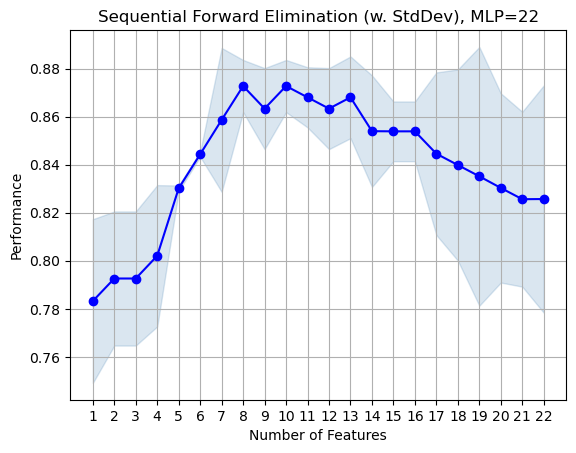

In [72]:
num_neur = 22
mlp_wrapper = MLPClassifier(max_iter = 500, random_state=714, activation='logistic', solver = 'adam' , hidden_layer_sizes = num_neur, batch_size=n_obs)
sfs_be = SFS(mlp_wrapper, 
           k_features=(1,22), 
           forward=True, 
           floating=False, 
           scoring='accuracy',
           cv=3)

sfs_fw = sfs_be.fit(X_Diseño_preprocesado, Y_Diseño)

# Representar los resultados
fig1 = plot_sfs(sfs_fw.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Elimination (w. StdDev), MLP=' + str(num_neur))
plt.grid()
plt.show()

wrapped_forward = pd.DataFrame.from_dict(sfs_fw.get_metric_dict()).T

In [73]:
features = wrapped_forward.loc[8,'feature_names']
print(f'Las variables obtenidas son: {features}')

Las variables obtenidas son: ('exang', 'ca', 'cp_1.0', 'cp_2.0', 'cp_4.0', 'slope_1.0', 'thal_3.0', 'thal_7.0')


Tras hacer estos dos métodos, vamos a ver con que variables de ambas selecciones nos quedamos. Viendo las gráficas, estamos entre coger los 6 primeros de backward y los 8 primeros de forward (ya que ambos dan un accuracy idéntico), por lo que vamos a ver la desviación estandar:

In [83]:
print(wrapped_forward['std_dev'][8])
print(wrapped_backward['std_dev'][6])

0.010849447486997286
0.010849447486997286


Al tener ambos una desviación y accuracy idénticos, vamos a seleccionar el más simple, es decir, las 6 variables de seleccionadas en backward.

In [117]:
MLP_features = list(wrapped_backward.loc[6,'feature_names'])

Tras realizar ambos metodos wrapper, nos quedamos con el utiliza forward selection porque nos da unos mejores resultados. Obtenemos un modelo mas sencillo al solo quedarnos con 7 características en comparación a las 8 del metodo backward, y con un accuracy más alto nos proporciona también una menor desviación típica.

Ahora vamos a obtener la predicción de nuestro conjunto de test utilizando la red neurona pasada al wrapped elegido y con las características que hemos obtenido.

Ya que tenemos las salidas predichas con nuestro modelo vamos a analizar las figuras de mérito.

In [ ]:
# Modelo
X_diseno_wrapped = X_Diseño_preprocesado[MLP_features]
mlp_wrapper = MLPClassifier(max_iter = 500, random_state=714, activation='logistic', solver = 'adam' , hidden_layer_sizes = num_neur, batch_size=n_obs)
mlp_wrapper.fit(X_diseno_wrapped,Y_Diseño)
Y_output_wrapper = mlp_wrapper.predict(X_test_preprocesado[MLP_features])
# Figuras de mérito
accuracy_wrapper = accuracy_score(Y_test,Y_output_wrapper)
f1_wrapper = f1_score(Y_test,Y_output_wrapper)
precision_wrapper = precision_score(Y_test,Y_output_wrapper)
recall_wrapper = recall_score(Y_test,Y_output_wrapper)

figuras_wrapper = {'metodo':['MLP_WRAPPER'],'accuracy':[accuracy_wrapper],'f1_score':[f1_wrapper],'precision':[precision_wrapper],'recall':[recall_wrapper]}
figuras_wrapper = pd.DataFrame(figuras_wrapper)
figuras_wrapper

,metodo,accuracy,f1_score,precision,recall
0,MLP_WRAPPER,0.802198,0.769231,0.789474,0.75


De la misma forma que en la regresión, el hacer feature selction obtenemos un desempeño algo inferior. Como se ha dicho anteriormente, a priori nos quedaríamos con una selección de todas las variables, puesto que hay una diferencia significante. Sin embargo, si por computación fuese necesario, podríamos usar solo esas 6 variables para el modelo haciendo un trade-off.


## Sección 4: Comparación de resultados

Para comparar los distintos resultados obtenidos, haremos uso de una tabla.

In [166]:
tabla_Resultados = {
'RegresionLogistica_reg':     [0.846154,	0.815789,	0.861111,	0.775],
'RegresionLogistica_wrapped': [0.791209,	0.759494,	0.769231,	0.75],
'MLP_1layer':                 [0.846154,	0.820513,	0.842105,	0.8],
'MLP_1layer_wrapperd':        [0.802198,	0.769231,	0.789474,	0.75]
}
tabla_Resultados = pd.DataFrame(tabla_Resultados, index=['Accuracy', 'F1_score', 'Precisión', 'Recall'])
tabla_Resultados.T

,Accuracy,F1_score,Precisión,Recall
RegresionLogistica_reg,0.846154,0.815789,0.861111,0.775
RegresionLogistica_wrapped,0.791209,0.759494,0.769231,0.750
MLP_1layer,0.846154,0.820513,0.842105,0.800
MLP_1layer_wrapperd,0.802198,0.769231,0.789474,0.750


Con esta tabla podemos hacer una comparacion directa con los 4 modelos. En primer lugar, se observa que apenas hay diferencias entre usar regresión logística y usar un mlp, por lo que por simplicidad computacional es más interesante quedarnos este primero. En segundo lugar, las diferencias entre quitar o no variables son significativas, por lo que, a no ser que necesitasemos optimizar lo que tarda en realizarse la predicción, a priori es mas interesante optar por quedarnos con todas las variables (que no son realmente muchas). Para finalizar, sí que es cierto que el mlp tiene mejores prestaciones a la hora de predecir bien los verdaderos postivios (recall), y en nuestro caso (debido a que predecimos problemas de corazón) esto podría ser relevante a la hora de elegir el modelo, puesto que, en general, pesa más no predecir un positivo que predecir mal un positivo (suele ser peor no tratar una afección cardíaca a tratala no habiedola). Además, al indicar a alguien como negativo, probablemente sea descartado directamente y no se trate a tiempo, mientras que un falso positivo se puede descartar a posteriori durante el tratamiento con más pruebas y viendo como avanza el paciente.

Con todo esto, hemos concluido que el mejor modelo para esta tarea será el MLP con 1 capa de 22 neuronas. Por un lado, ese mejor recall nos interesa mucho debido a lo comentado anteriormente. Por otro lado, computacionalmente no debería haber problemas puesto que la red no es muy extensa y además nunca se trabajará con un volumen muy grande de datos (si suponemos que el modelo se empleara en hospitales, un hospital no va a tener millones de pacientes, solo de el orden de miles o diezmiles, y eso dando por hecho que se haga con todos a la vez, lo cual es muy raro que suceda). Al final este modelo se solerá aplicar de paciente en paciente cuando haya una cierta duda de si tiene un problema cardíaco, por lo que la diferencia de tiempo será ridiculamente baja.

Para obtener los estadísticos de cada una de las figuras de mérito una posible opción sería realizar las predicciones en nuestro conjunto de test mediante batches. Así obteniendo distintos valores de una misma figura de mérito para cada batch y pudiendo obtener distintos estadísticos como la media o la desviación típica.